## Hackathon 3 : Sentiment Classification

<b>Problem Statement</b>
<p>Twitter has now become a useful way to build one's business as it helps in giving the brand a voice and a personality. The platform is also a quick, easy and inexpensive way to gain valuable insight from the desired audience. Identifying the sentiments about the product/brand can help the business take better actions.</p>

You have with you evaluated tweets about multiple brands. The evaluators(random audience) were asked if the tweet expressed positive, negative, or no emotion towards a product/brand and labelled accordingly.

<b>Dataset Description</b> 
<p>This dataset contains around 7k tweet text with the sentiment label.

The file train.csv has 3 columns

tweet_id - Unique id for tweets. tweet - Tweet about the brand/product sentiment - 0: Negative, 1: Neutral, 2: Positive, 3: Can't Tell </p>

<b>Evaluation Metric</b> 
<p> We will be using ‘weighted’ F1-measure as the evaluation metric for this competition. For more information on the F1-metric refer to https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html  </p>

<b>Submission format</b> 
<p> Submission file should have two columns, one for tweet_id and sencond for sentiment [0: Negative, 1: Neutral, 2: Positive, 3: Can't Tell]. A sample submission file has also been attached for reference. </p>

## Start of Notebook

#### Why are we doing this
- To Classify the Tweets into positive , neutral , negative, Cant tell
- To Identify sentiments of product/brand

#### Stakeholders:
- Customer of Withwicky 
- DataScience head or Project Manager of WithWicky

In [116]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from html.parser import HTMLParser
from textblob import TextBlob
import string
from spellchecker import SpellChecker
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer,TfidfTransformer
from emot.emo_unicode import UNICODE_EMO, EMOTICONS
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import BernoulliNB, MultinomialNB

import plotly.offline as pyo
from plotly import graph_objs as go
# Set notebook mode to work in offline
pyo.init_notebook_mode()

#### Import DataSet

In [53]:
traindf = pd.read_csv("train.csv")
testdf = pd.read_csv("test.csv")

In [54]:
traindf.dtypes

tweet_id      int64
tweet        object
sentiment     int64
dtype: object

## EDA

#### Checking Train DataSet

In [55]:
traindf.head()

tweet_id                                              tweet  sentiment
0      1701  #sxswnui #sxsw #apple defining language of tou...          1
1      1851  Learning ab Google doodles! All doodles should...          1
2      2689  one of the most in-your-face ex. of stealing t...          2
3      4525  This iPhone #SXSW app would b pretty awesome i...          0
4      3604  Line outside the Apple store in Austin waiting...          1

In [56]:
tweets_text = traindf.tweet.str.cat()
emos = set(re.findall(r" ([xX:;][-']?.) ",tweets_text))
emos_count = []
for emo in emos:
    emos_count.append((tweets_text.count(emo), emo))
sorted(emos_count,reverse=True)

[(95, ':)'),
 (30, ';)'),
 (24, 'XD'),
 (21, ':-)'),
 (16, ':('),
 (9, ';-)'),
 (7, ':D'),
 (6, ':-('),
 (5, ':P'),
 (3, 'xD'),
 (3, ':s'),
 (2, ';]'),
 (2, '::'),
 (2, ':-\\'),
 (2, ':-D'),
 (1, ':p'),
 (1, ':-|')]

In [57]:
HAPPY_EMO = r" ([xX;:]-?[dD)]|:-?[\)]|[;:][pP]) "
SAD_EMO = r" (:'?[/|\(]) "
print("Happy emoticons:", set(re.findall(HAPPY_EMO, tweets_text)))
print("Sad emoticons:", set(re.findall(SAD_EMO, tweets_text)))

Happy emoticons: {':-D', ';)', ':)', ':p', 'xD', 'XD', ':P', ':-)', ':D', ';-)'}
Sad emoticons: {':('}


In [58]:
temp = traindf.groupby('sentiment').count()['tweet'].reset_index().sort_values(by='tweet',ascending=False)

In [59]:
temp

sentiment  tweet
1          1   4310
2          2   2382
0          0    456
3          3    125

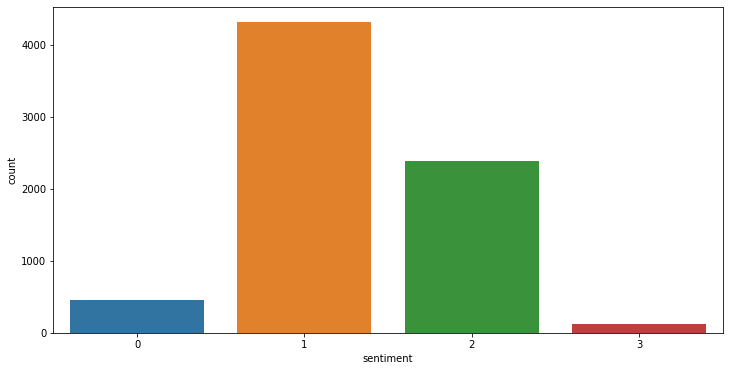

In [60]:
plt.figure(figsize=(12,6))
sns.countplot(x='sentiment',data=traindf)

In [61]:
fig = go.Figure(go.Funnelarea(
    text =temp.sentiment,
    values = temp.tweet,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))

fig.show()

In [62]:
traindf.info

<bound method DataFrame.info of       tweet_id                                              tweet  sentiment
0         1701  #sxswnui #sxsw #apple defining language of tou...          1
1         1851  Learning ab Google doodles! All doodles should...          1
2         2689  one of the most in-your-face ex. of stealing t...          2
3         4525  This iPhone #SXSW app would b pretty awesome i...          0
4         3604  Line outside the Apple store in Austin waiting...          1
...        ...                                                ...        ...
7269      3343  @mention Google plze Tammi.  I'm in middle of ...          1
7270      5334  RT @mention ÷¼ Are you all set? ÷_ {link} ÷...          1
7271      5378  RT @mention Aha! Found proof of lactation room...          1
7272      2173  We just launched our iPad app at #SXSW! Get al...          1
7273      3162  The next fin serv battle is vs Apple, GOOG, Mo...          1

[7274 rows x 3 columns]>

In [63]:
testdf.info

<bound method DataFrame.info of       tweet_id                                              tweet
0         7506  Audience Q: What prototyping tools do you use?...
1         7992  At SXSW? Send Your Best Photos &amp; Videos to...
2          247  @mention  and here's a pic of you winning your...
3         7688  Google Marissa Mayer: mobile phone as a cursor...
4         3294    #SXSW Google maps is even cooler than I thought
...        ...                                                ...
1814      1550  @mention @mention @mention Hmmm....how fast ca...
1815      1933  Samsung Galaxy S II Appears At FCC And Team An...
1816      9052  @mention You could buy a new iPad 2 tmrw at th...
1817      4219  Wow very long queue of people at apple pop up ...
1818      7210  Privacy Could Headline Google Circles Social N...

[1819 rows x 2 columns]>

In [64]:
traindf.dtypes

tweet_id      int64
tweet        object
sentiment     int64
dtype: object

In [65]:
traindf.head()


tweet_id                                              tweet  sentiment
0      1701  #sxswnui #sxsw #apple defining language of tou...          1
1      1851  Learning ab Google doodles! All doodles should...          1
2      2689  one of the most in-your-face ex. of stealing t...          2
3      4525  This iPhone #SXSW app would b pretty awesome i...          0
4      3604  Line outside the Apple store in Austin waiting...          1

In [66]:
TextBlob("This iPhone SXSW app would b pretty awesome").correct()

TextBlob("His shone SXSW pp would b pretty awesome")

In [67]:
traindf.info

<bound method DataFrame.info of       tweet_id                                              tweet  sentiment
0         1701  #sxswnui #sxsw #apple defining language of tou...          1
1         1851  Learning ab Google doodles! All doodles should...          1
2         2689  one of the most in-your-face ex. of stealing t...          2
3         4525  This iPhone #SXSW app would b pretty awesome i...          0
4         3604  Line outside the Apple store in Austin waiting...          1
...        ...                                                ...        ...
7269      3343  @mention Google plze Tammi.  I'm in middle of ...          1
7270      5334  RT @mention ÷¼ Are you all set? ÷_ {link} ÷...          1
7271      5378  RT @mention Aha! Found proof of lactation room...          1
7272      2173  We just launched our iPad app at #SXSW! Get al...          1
7273      3162  The next fin serv battle is vs Apple, GOOG, Mo...          1

[7274 rows x 3 columns]>

## Stop Words Removal

In [68]:
def RemoveEnglishStopWords(df):
    stop_words = set(stopwords.words('english'))
    df['tweet'] = df['tweet'].apply(lambda x: [word for word in x if not word in stop_words])
    return df

In [69]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

#### Data Cleaning

In [70]:
html_parser = HTMLParser()

In [71]:
# Function for converting emoticons into word
def convert_emoticons(text):
    for emot in EMOTICONS:
        text = re.sub(u'('+emot+')', " ".join(EMOTICONS[emot].replace(",","").split()), text)
    return text

In [72]:
convert_emoticons("Awwww yeah!!! RT @mention Congrats to @mention on winning the last @mention #iPad case for her boyfriend aw :) #SXSW #cbatsxsw")

'Awwww yeah!!! RT @mention Congrats to @mention on winning the last @mention #iPad case for her boyfriend aw Happy face or smiley #SXSW #cbatsxsw'

In [75]:
traindf.tweet[220]

'Awwww yeah!!! RT @mention Congrats to @mention on winning the last @mention #iPad case for her boyfriend aw :) #SXSW #cbatsxsw'

In [76]:
def dataCleaning(df):
    df['tweet'] = df['tweet'].astype(str)
    
    #removing @mention
    df['tweet']= df['tweet'].apply(lambda x: re.sub('(@[mention]+)',' ',x))
    
    #removing @handles , since trending tweets are on Hashtags
    df['tweet']= df['tweet'].apply(lambda x: re.sub('(@[A-Za-z0-9]+)',' ',x))
    
     #removing Http links , since trending tweets are on Hashtags
    df['tweet']= df['tweet'].apply(lambda x: re.sub('http\S+',' ',x))
    
    #converting emoticon
    df['tweet']= df['tweet'].apply(lambda x: convert_emoticons(x))
    
    # remove numbers
    df['tweet']= df['tweet'].apply(lambda x: re.sub(r'\d+', ' ', x))
    

    # remove punctuations and convert characters to lower case
    df['tweet'] = df['tweet'].apply(lambda x: "".join([char.lower() for char in x if char not in string.punctuation]))
    
    #converting Html Encoding
    
    df['tweet']= df['tweet'].apply(lambda x: html_parser.unescape(x))
    
    #removing #HashTags 
    #df['tweet']= df['tweet'].apply(lambda x: re.sub('(#[A-Za-x0-9\\_\\]+)',' ',x))
    
    # #removing '#' symbol 
    df['tweet']= df['tweet'].apply(lambda x: re.sub('(#+)',' ',x))
     
    
    #replacing double whitespace with single 
    df['tweet']= df['tweet'].apply(lambda x: re.sub(' +', ' ',x))
    
    #Removing RT
    df['tweet']= df['tweet'].apply(lambda x: re.sub('(rt)\W', ' ',x))
    
    
    
    
#     #Spelling Correction
#     df['tweet']= df['tweet'].apply(lambda x: TextBlob(x).correct() )
      
    
    return df

In [77]:
traindf = dataCleaning(traindf)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning:

The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.



In [78]:
traindf.tweet[220]

'awwww yeah  congrats to on winning the last ipad case for her boyfriend aw happy face or smiley sxsw cbatsxsw'

In [79]:
traindf.head()

tweet_id                                              tweet  sentiment
0      1701  sxswnui sxsw apple defining language of touch ...          1
1      1851  learning ab google doodles all doodles should ...          1
2      2689  one of the most inyourface ex of stealing the ...          2
3      4525  this iphone sxsw app would b pretty awesome if...          0
4      3604  line outside the apple store in austin waiting...          1

In [80]:


#nltk.download('wordnet')
def stem_tokenize(text):
    stemmer = SnowballStemmer("english")
    #stemmer = WordNetLemmatizer()
    return [stemmer.lemmatize(token) for token in word_tokenize(text)]

def lemmatize_tokenize(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in word_tokenize(text)]

tfidf = TfidfVectorizer(stop_words="english")

vector_tfidf = tfidf.fit_transform(traindf["tweet"])



In [102]:
X_tfidf = vector_tfidf.toarray()


In [109]:
X_train,X_test,y_train,y_test = train_test_split(traindf['tweet'],traindf['sentiment'],test_size=0.4,random_state=42)

In [125]:
X_train.head()

2642    in case my fairy god mother reading mail my ìù...
5378    any technologist who thinks quotsearch is hist...
7095     were cohosting a cmty mngr meetup w at etsy a...
4084    checking out ipad design headaches author josh...
4475    i just realized my iphones gonna go nuts with ...
Name: tweet, dtype: object

In [ ]:
X_train_tfidf= tfidf.fit_transform(X_train)


log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train,y_train)

tfidf_acc = log_reg.score(X_test,y_test)

nb = MultinomialNB()

nb.fit(X_train,y_train)

nb_acc = accuracy_score(X_test,y_test)

lr = LogisticRegression()
bnb = BernoulliNB()
mnb = MultinomialNB()

models = {
    'logitic regression': lr,
    'bernoulliNB': bnb,
    'multinomialNB': mnb,
}


for model in models.keys():
    scores = cross_val_score(models[model], learning_data, sentiments_learning, scoring="f1", cv=10)
    print("===", model, "===")
    print("scores = ", scores)
    print("mean = ", scores.mean())
    print("variance = ", scores.var())
    models[model].fit(learning_data, sentiments_learning)
    print("score on the learning data (accuracy) = ", accuracy_score(models[model].predict(learning_data), sentiments_learning))
    print("")

In [110]:
tfidf.fit_transform(X_train)

<4364x7207 sparse matrix of type '<class 'numpy.float64'>'
	with 44691 stored elements in Compressed Sparse Row format>

In [ ]:
tfidf.fit()

## Other Appproach

In [126]:
count_vect = CountVectorizer()

In [127]:
X_train_tf = count_vect.fit_transform(X_train)

In [128]:
tfidf_transformer = TfidfTransformer()

In [129]:
X_train_tfidf = tfidf_transformer.fit_transform(X_train_tf)

In [130]:
nb= MultinomialNB() 

In [175]:
X_train_tfidf.shape

(4364, 7461)

In [132]:
nb.fit(X_train_tfidf, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [133]:
X_test_tf = count_vect.transform(X_test)
X_test_tfidf = tfidf_transformer.fit_transform(X_test_tf)

In [134]:
predicted = nb.predict(X_test_tfidf)

In [174]:
predicted.shape

(2910,)

In [135]:
accuracy_score(y_test,predicted)

0.638487972508591

## TEST

In [155]:
testdf = pd.read_csv("test.csv")

In [156]:
testdf = dataCleaning(testdf)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning:

The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.



In [157]:
testdf.head()

tweet_id                                              tweet
0      7506  audience q what prototyping tools do you use s...
1      7992  at sxsw send your best photos amp videos to li...
2       247   and heres a pic of you winning your ipad unsi...
3      7688  google marissa mayer mobile phone as a cursor ...
4      3294     sxsw google maps is even cooler than i thought

In [158]:
testdf.shape

(1819, 2)

In [159]:
test_id_col = testdf['tweet_id']

In [160]:
test_id_col.shape

(1819,)

In [161]:
test_df_drop_id = testdf.drop(['tweet_id'],axis=1)

In [162]:
test_df_drop_id.shape

(1819, 1)

In [163]:
test_df_drop_id['tweet']

0       audience q what prototyping tools do you use s...
1       at sxsw send your best photos amp videos to li...
2        and heres a pic of you winning your ipad unsi...
3       google marissa mayer mobile phone as a cursor ...
4          sxsw google maps is even cooler than i thought
                              ...                        
1814     hmmmhow fast can apple build a new store in t...
1815    samsung galaxy s ii appears at fcc and team an...
1816     you could buy a new ipad tmrw at the apple po...
1817    wow very long queue of people at apple pop up ...
1818    privacy could headline google circles social n...
Name: tweet, Length: 1819, dtype: object

In [176]:
test_df_drop_id['tweet']

0       audience q what prototyping tools do you use s...
1       at sxsw send your best photos amp videos to li...
2        and heres a pic of you winning your ipad unsi...
3       google marissa mayer mobile phone as a cursor ...
4          sxsw google maps is even cooler than i thought
                              ...                        
1814     hmmmhow fast can apple build a new store in t...
1815    samsung galaxy s ii appears at fcc and team an...
1816     you could buy a new ipad tmrw at the apple po...
1817    wow very long queue of people at apple pop up ...
1818    privacy could headline google circles social n...
Name: tweet, Length: 1819, dtype: object

In [177]:
testdf_tf = count_vect.transform(test_df_drop_id['tweet'])

In [178]:
testdf_tfidf = tfidf_transformer.transform(testdf_tf)

In [179]:
testdf_tfidf.shape

(1819, 7461)

In [180]:
predict = nb.predict(testdf_tfidf)

In [181]:
predict

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [173]:
predict.shape

(1,)

In [182]:
test_df_drop_id['sentiment']= nb.predict(testdf_tfidf)

In [183]:
submissions_nb = pd.concat([test_id_col, test_df_drop_id['sentiment']], axis=1) 

In [184]:
submissions_nb.to_csv('submissions_NB.csv', index=False) 